In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

%matplotlib inline

In [47]:
# Load the image data from a FITS file
with fits.open("image.fit") as hdul:
    hdul.info()
    image_data = hdul[0].data

Filename: image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (3008, 3008, 3)   int16 (rescales to uint16)   


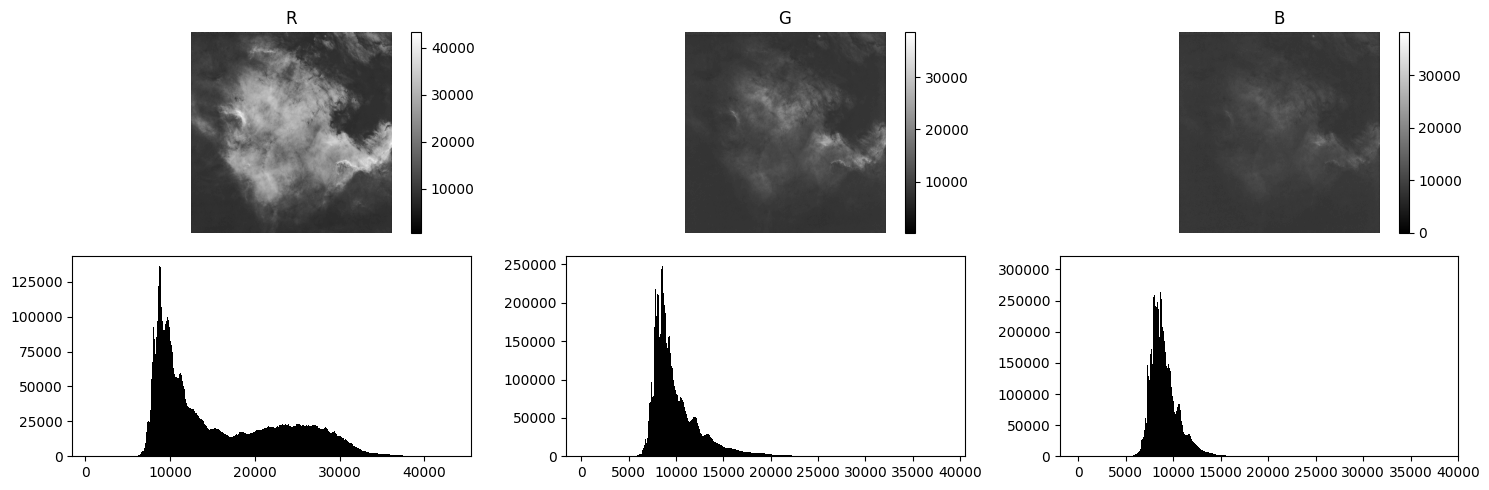

In [48]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i, channel in zip(range(3), ['R', 'G', 'B']):
    # Plot the channel image
    data = image_data[i]
    im = axes[0, i].imshow(data, cmap='gray')
    axes[0, i].set_title(channel)
    axes[0, i].axis('off')
    fig.colorbar(im, ax=axes[0, i])

    # Plot the histogram below the image
    axes[1, i].hist(data.flatten(), bins=512, color='black')

plt.tight_layout()
plt.show()

In [49]:
def stats(data):
    # Create a DataFrame to display the results
    stats_df = pd.DataFrame({
        'Min': np.min(data, axis=(1, 2)),
        'Max': np.max(data, axis=(1, 2)),
        'Mean': np.mean(data, axis=(1, 2)),
        'MAD': np.array([np.mean(np.abs(data[i] - np.mean(data[i]))) for i in range(data.shape[0])]),
        'Stdev': np.std(data, axis=(1, 2))
    }, index=[f'Dataset {i+1}' for i in range(data.shape[0])])
    print(stats_df)

In [50]:
stats(image_data)

           Min    Max          Mean          MAD        Stdev
Dataset 1  603  43335  16012.614090  6643.215626  7559.022440
Dataset 2  299  38573   9986.048937  1929.281651  2622.078607
Dataset 3    0  38135   9049.437072  1110.113141  1473.292987


In [56]:
blk_p_adj = 1.0
blk_p = np.min(image_data, axis=(1,2)) + blk_p_adj * (np.mean(image_data, axis=(1,2)) - np.min(image_data, axis=(1,2)))
print(blk_p)

[16012.61409037  9986.04893721  9049.43707239]
